In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from UliEngineering.EngineerIO import format_value
from si_prefix import si_format
import plecs_helper as helper
%matplotlib
%matplotlib inline

# Imports and setup
from pint import UnitRegistry
from scipy.signal import find_peaks
from scipy.optimize import fsolve

# pandas display using scientific notation
# pd.set_option('display.float_format', lambda x: f'{x:.3e}')

# use pint
units = UnitRegistry()
units.default_format = "~P.2f"

def to_decibels(arr, dc_gain = 0):
    return np.log10(np.abs(arr)) * 20 + dc_gain

Using matplotlib backend: TkAgg


# Independent Steps
Hi Beat! I found the things wrong with my original analysis. Because the frequency $\omega$ is measured in Hertz, I thought it was acceptable to use the impedance equation $Z = \frac{1}{j \omega C}$ for a capacitor. However, the factor of $2 \pi$ in the equation is actually important for converting Hertz *into* radians per second so that the relationship becomes valid. The correct equation is $Z = \frac{1}{2 \pi j \omega C}$. This fixed a vertical and horizontal offset of my $Z_c$ bode plot.

The other thing wrong was that I used the equation $\text{dB} = 20 \cdot \text{ln}(a)$ instead of the correct $\text{dB} = 20 \cdot \text{log}_{10}(a)$. This is a particularly pernicious mistake because numpy uses the function `log` for $ln$. This is why I was seeing slopes for $Z_c$ which were a factor of three steeper than expected from the equation.

I think that wrestling with this for many hours over the weekend and last night counts as significant independent steps. I had to look up old ISIM notes to derive the op-amp gain equation and puzzle over whether there were any other transfer functions or unaccounted for gains elsewhere in the circuit. I feel like I understand our hardware circuit and schematic better as a result.

# Lab 10
### Ian Eykamp

As expected, the output voltage jumped to a value of 9.60V and an input current of 1.30A after reaching steady state (very quickly on a human timescale). This is because the voltage divider `R2 = 4.3kOhm`, `R3 = 1.5kOhm` creates a middle node voltage of 2.5V when the input voltage is 9.67V.

For Lab 10, we used the provided feedback components `C1 = 47nF`, `R5 = 510Ohm`, and `C2 = 10nF`, with `C2` in parallel with `(C1 + R5)` in series.

<img src="Zc_block.jpg" width="600" height="400">

The impedance value of Zc is obtained directly by substituting in $Z = R$ for the resitor and $Z = \frac{1}{2 \pi j \omega C}$ for the capacitors. By parallel and series addition, we have $Z_c = \frac{1}{(\frac{1}{(R_5 + \frac{1}{2 \pi j \omega C_1})} + \frac{1}{(\frac{1}{2 \pi j \omega C_2})})}$.

The op-amp is configured as an inverting amplifier with gain $\frac{Z_c}{R_2}$, referenced to 2.5V. the bottom resistor `R3` does not contribute to the transfer function, but it does affect the DC `V-` voltage. Fortunately, when Vout = 10V, the `R3`-`R4` voltage divider is also referenced to 2.5V, so the amplifier will work as expected without any offset.

The resulting bode plot indicates Zc has an integrator (pole at $\omega = 0Hz$) as well as a pole-zero combination above the switching frequency (zero at $\omega = 40kHz$, pole at $\omega = 250kHz$). The dashed line shows a transfer function I recreated with these characteristics; it matches nearly perfectly with the direct equation.

The expected output voltage given the voltage divider resistors is: 9.67 V
Lead element center voltage (ω_c): 14.39 kHz


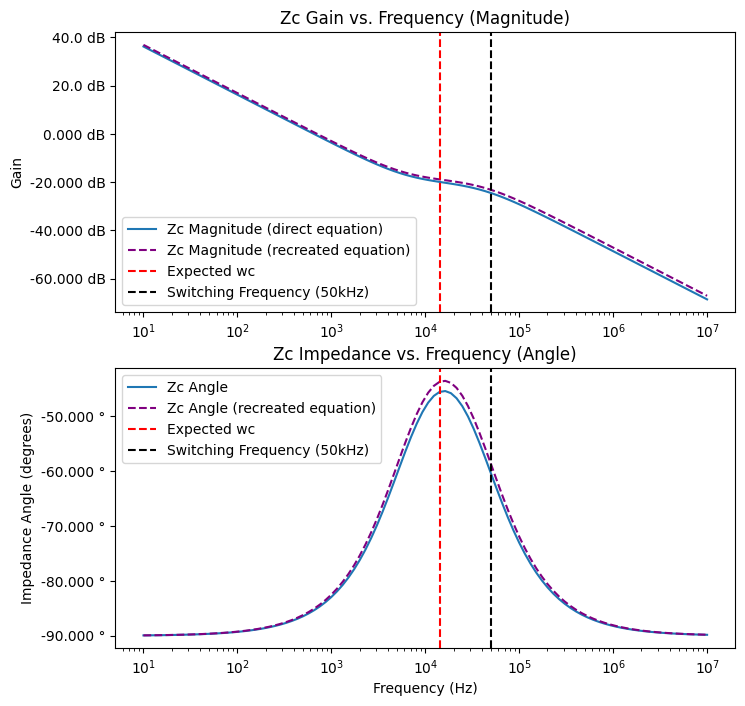

In [117]:
R2 = 4.3 # * units.kiloohm
R3 = 1.5 # * units.kiloohm
Vtarget = 2.5 * (R2 + R3) / R3 # * units.volt
print(f"The expected output voltage given the voltage divider resistors is: {si_format(Vtarget, precision = 2)}V")

C1 = 47e-9 # * units.nanofarad
C2 = 10e-9 # * units.nanofarad
R5 = 510 # * units.ohm
w = np.logspace(1, 7, 100) # * units.hertz
def get_Zc(my_w):
    # my_Zc = 1 / (1 / (R5 + 1 / (1j * my_w * C1)) + 1 / (1 / (1j * my_w * C2))) / 4.3e3 # kOhm
    my_Zc = 1 / (1 / (R5 + 1 / (2 * np.pi * 1j * my_w * C1)) + 1 / (1 / (2 * np.pi * 1j * my_w * C2))) / 4.3e3 # kOhm
    return my_Zc
Zc = get_Zc(w) # direct equation
Zc2 = (2 * np.pi * 1j * w / (40e3) + 1) / ((2 * np.pi * 1j * w / (1.9e7)) * (2 * np.pi * 1j * w / (250e3) + 1)) / 4.3e3 # kOhm # recreated equation

expected_wc = 1 / (R5 * np.sqrt(C1 * C2)) / 2 / np.pi # to get it into Hz
print(f"Lead element center voltage (ω_c): {si_format(expected_wc, precision = 2)}Hz")

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain", "dB", title = "Zc Gain vs. Frequency (Magnitude)", ax = ax1)
ax1.semilogx(w, to_decibels(Zc), linestyle = "solid", label = "Zc Magnitude (direct equation)")
ax1.semilogx(w, to_decibels(Zc2), linestyle = "dashed", color = "purple", label = "Zc Magnitude (recreated equation)")
ax1.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax1.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Impedance Angle (degrees)", "°", title = "Zc Impedance vs. Frequency (Angle)", ax = ax2)
ax2.semilogx(w, np.angle(Zc, deg = True), linestyle = "solid", label = "Zc Angle")
ax2.semilogx(w, np.angle(Zc2, deg = True), linestyle = "dashed", color = "purple", label = "Zc Angle (recreated equation)")
ax2.axvline(x = expected_wc, linestyle = "dashed", color = "red", label = "Expected wc")
ax2.axvline(x = 50e3, linestyle = "dashed", color = "black", label = "Switching Frequency (50kHz)")
ax2.legend(loc = "upper left")
# ax2.set_ylim(-100, -80)

The Zc network consists of an integrator and a lead element centered around $\omega_c = 14.4kHz$. On the magnitude plot, this appears as a never-ending increase in magnitude towards low frequencies and a slight horizontal jog at $\omega_c$. On the angle plot, this appears as a constant -90° phase shift with a large phase boost centered around $\omega_c$. This will help increase the phase margin at $\omega_c$, which is chosen to be the cross-over frequency of the compensator.

## Bode Plots

<img src="whole_network.jpg" width="600" height="400">

In [107]:
# Import data
open_loop_bode = pd.read_csv("bode_plots/open-loop.csv")
closed_loop_bode = pd.read_csv("bode_plots/closed-loop.csv")
step_response_df = pd.read_csv("bode_plots/step-resp.csv")
print(open_loop_bode.columns)

Index(['Frequency (Hz)', 'Channel 1 Magnitude (dB)',
       'Channel 2 Magnitude (dB)', 'Channel 2 Phase (deg)'],
      dtype='object')


### Open-Loop Transfer Function (GOL)

Open-loop gain cross-over frequency: 3.53 kHz
Open-loop gain cross-over phase margin: 42.26°
Open-loop phase cross-over frequency: 17.03 kHz
Open-loop phase cross-over gain margin: -17.87dB
3527.032562051862
86    3527.032562
Name: Frequency (Hz), dtype: float64


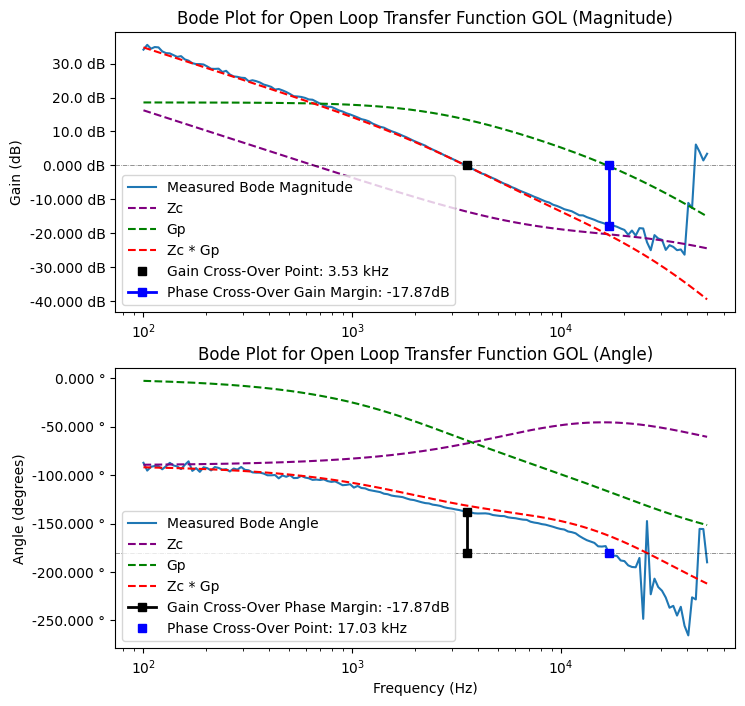

In [184]:
w = open_loop_bode["Frequency (Hz)"]
Zc = get_Zc(w)
dc_gain = 18.58 # dB
# G = 1 / ((w * 1j / (1.8e3)) + 1) / ((w * 1j / (2e4)) + 1) * 10**(dc_gain / 20) # middle output voltage
G = 1 / ((w * 1j / 2.4e3) + 1) / ((w * 1j / 2.4e4) + 1) * 10**(dc_gain / 20) # optimized for 10V out

open_loop_gc = open_loop_bode[(open_loop_bode["Channel 2 Magnitude (dB)"] < 0) & (open_loop_bode["Frequency (Hz)"] < 2e4)].iloc[0]
open_loop_gc_freq = open_loop_gc["Frequency (Hz)"]
open_loop_gc_phase_margin = 180 - np.abs(open_loop_gc["Channel 2 Phase (deg)"])
print(f"Open-loop gain cross-over frequency: {si_format(open_loop_gc_freq, precision = 2)}Hz")
print(f"Open-loop gain cross-over phase margin: {np.round(open_loop_gc_phase_margin, 2)}°")

open_loop_pc = open_loop_bode[(open_loop_bode["Channel 2 Phase (deg)"] < -180)].iloc[0]
open_loop_pc_freq = open_loop_pc["Frequency (Hz)"]
open_loop_pc_gain_margin = open_loop_pc["Channel 2 Magnitude (dB)"]
print(f"Open-loop phase cross-over frequency: {si_format(open_loop_pc_freq, precision = 2)}Hz")
print(f"Open-loop phase cross-over gain margin: {np.round(open_loop_pc_gain_margin, 2)}dB")


fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Open Loop Transfer Function GOL (Magnitude)", ax = ax1)
ax1.semilogx(open_loop_bode["Frequency (Hz)"], open_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(Zc), linestyle = "dashed", color = "purple", label = "Zc")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G), linestyle = "dashed", color = "green", label = "Gp")
ax1.semilogx(open_loop_bode["Frequency (Hz)"], to_decibels(G * Zc), linestyle = "dashed", color = "red", label = "Zc * Gp")
ax1.axhline(y = 0, color = "black", linestyle = "dashdot", linewidth = 0.5, alpha = 0.6)
ax1.semilogx(open_loop_gc_freq, 0, marker = 's', markersize = 6, markerfacecolor = "black", markeredgecolor = "black", color = "white", label = f"Gain Cross-Over Point: {si_format(open_loop_gc_freq, precision = 2)}Hz")
ax1.semilogx([open_loop_pc_freq, open_loop_pc_freq], [0, open_loop_pc_gain_margin], marker = 's', markersize = 6, markerfacecolor = "blue", markeredgecolor = "blue", color = "blue", linewidth = 2, label = f"Phase Cross-Over Gain Margin: {np.round(open_loop_pc_gain_margin, 2)}dB")
ax1.legend(loc = "lower left")
print(np.array(open_loop_gc_freq))
print(open_loop_bode[open_loop_bode["Frequency (Hz)"] == open_loop_gc_freq]["Frequency (Hz)"])

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Open Loop Transfer Function GOL (Angle)", ax = ax2)
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(open_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(Zc, deg = True), period = 360), linestyle = "dashed", color = "purple", label = "Zc")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G, deg = True), period = 360), linestyle = "dashed", color = "green", label = "Gp")
ax2.semilogx(open_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G * Zc, deg = True), period = 360), linestyle = "dashed", color = "red", label = "Zc * Gp")
ax2.axhline(y = -180, color = "black", linestyle = "dashdot", linewidth = 0.5, alpha = 0.6)
ax2.semilogx([open_loop_gc_freq, open_loop_gc_freq], [-180, -180 + open_loop_gc_phase_margin], marker = 's', markersize = 6, markerfacecolor = "black", markeredgecolor = "black", color = "black", linewidth = 2, label = f"Gain Cross-Over Phase Margin: {np.round(open_loop_gc_phase_margin, 2)}°")
ax2.semilogx(open_loop_pc_freq, -180, marker = 's', markersize = 6, markerfacecolor = "blue", markeredgecolor = "blue", color = "white", label = f"Phase Cross-Over Point: {si_format(open_loop_pc_freq, precision = 2)}Hz")
ax2.legend(loc = "lower left")

This bode plot was taken on one the upstream (closer to Vout) side of the feedback loop *with reference to* the downstream (closer to VFB) side of the injected current. Thus, the *response* of the system in this configuration corresponds with the **open-loop** transfer function $G_{OL}$, since the feedback loop is **factored out**.

As expected, the open-loop transfer function is a product of the compensator gain $Z_c$ and plant transfer function $G_p(s)$ obtained in Lab 9. It follows a trajectory towards infinite gain at DC from the compensator's integrating capacitor `C2`. The primary pole of the plant corresponds loosely with the plateau caused by the lead element so that the gain decreases roughly linearly (on the log scale) with frequency, at least up to around the switching frequency. The theoretical and measured curves match quite well for both the angle and the magnitude up to about 10kHz.

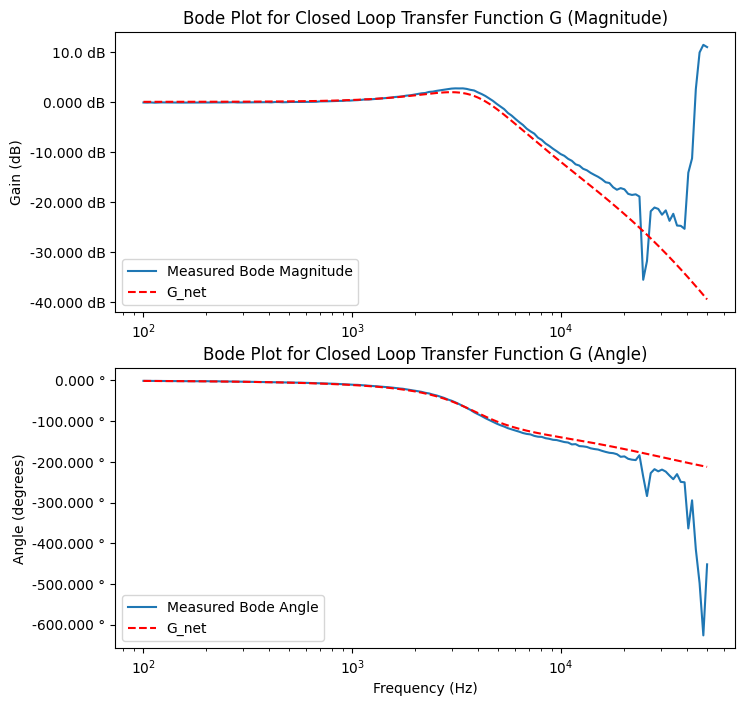

In [109]:
w = closed_loop_bode["Frequency (Hz)"]
G_new = G * Zc / (1 + G * Zc)

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (8, 8))
helper.axes_labels("", "Hz", "Gain (dB)", "dB", title = "Bode Plot for Closed Loop Transfer Function G (Magnitude)", ax = ax1)
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], closed_loop_bode["Channel 2 Magnitude (dB)"], linestyle = "solid", label = "Measured Bode Magnitude")
ax1.semilogx(closed_loop_bode["Frequency (Hz)"], to_decibels(G_new), linestyle = "dashed", color = "red", label = "G_net")
ax1.legend(loc = "lower left")

helper.axes_labels("Frequency (Hz)", "Hz", "Angle (degrees)", "°", title = "Bode Plot for Closed Loop Transfer Function G (Angle)", ax = ax2)
ax2.semilogx(closed_loop_bode["Frequency (Hz)"], np.unwrap(closed_loop_bode["Channel 2 Phase (deg)"], period = 360), linestyle = "solid", label = "Measured Bode Angle")
ax2.semilogx(closed_loop_bode["Frequency (Hz)"], np.unwrap(np.angle(G_new, deg = True), period = 360), linestyle = "dashed", color = "red", label = "G_net")
ax2.legend(loc = "lower left")